In [1]:
# pip install --upgrade nltk

Importing libraries

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk import ngrams
import re
from collections import defaultdict, Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
import numpy as np
from transformers import BertTokenizer, BertModel
import torch
import xgboost as xgb
import lightgbm as lgb
import catboost
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
print(nltk.__version__)

3.9.1


In [4]:
train = pd.read_csv("/kaggle/input/cyber-crime/train.csv")
test = pd.read_csv("/kaggle/input/cyber-crime/test.csv")

EDA

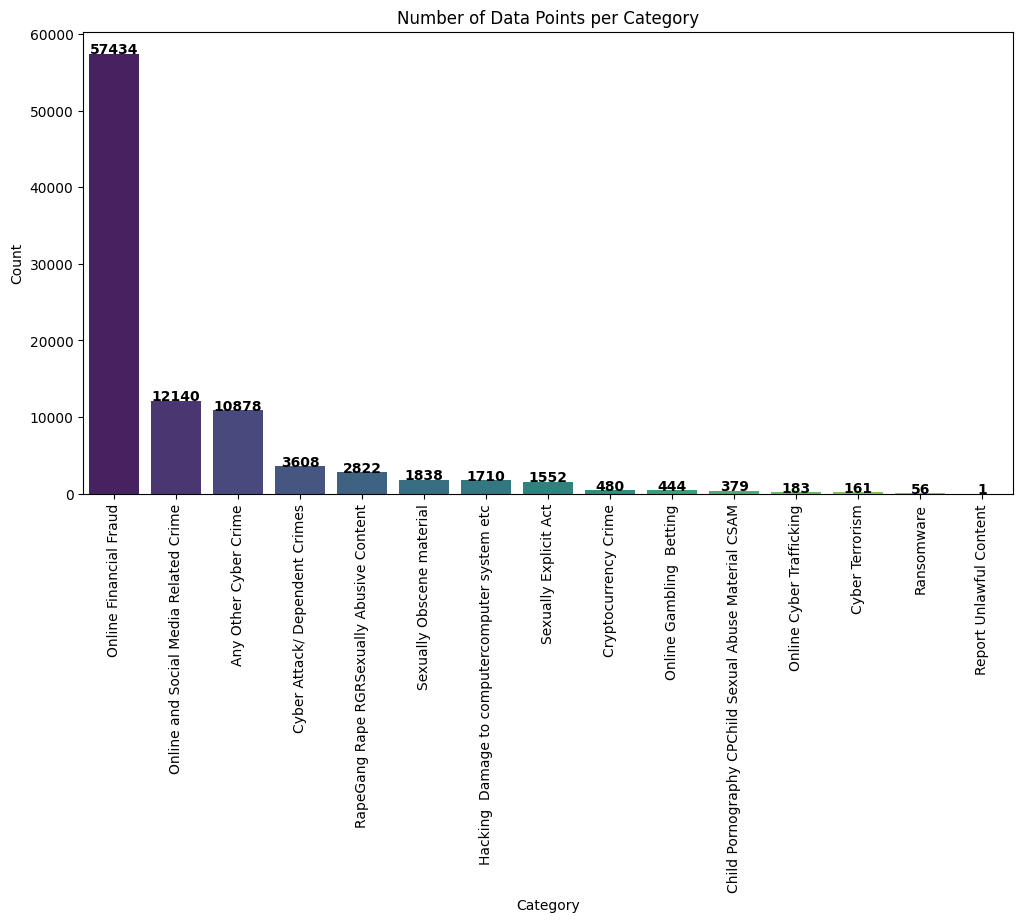

In [5]:
# 1. Plot for number of data points in each category
plt.figure(figsize=(12, 6))
category_counts = train['category'].value_counts().sort_values(ascending=False)
sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")
plt.title("Number of Data Points per Category")
plt.xlabel("Category")
plt.ylabel("Count")

# Annotate the count above each bar
for i, v in enumerate(category_counts.values):
    plt.text(i, v + 0.5, str(v), ha='center', fontweight='bold')

plt.xticks(rotation=90)  # Rotate x-ticks by 90 degrees
plt.show()

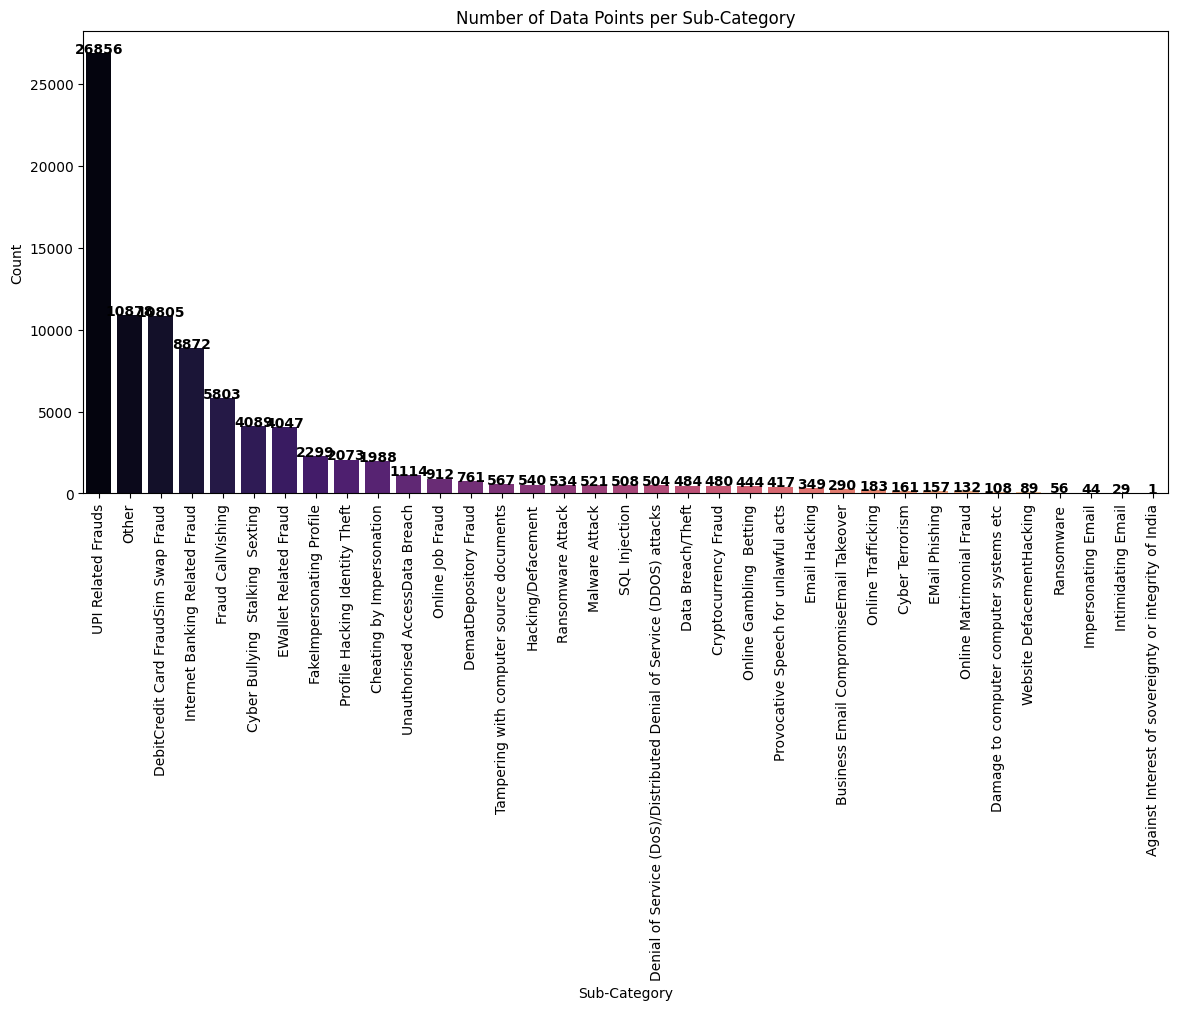

In [6]:
# 2. Plot for number of data points in each sub_category
plt.figure(figsize=(14, 6))
sub_category_counts = train['sub_category'].value_counts().sort_values(ascending=False)
sns.barplot(x=sub_category_counts.index, y=sub_category_counts.values, palette="magma")
plt.title("Number of Data Points per Sub-Category")
plt.xlabel("Sub-Category")
plt.ylabel("Count")

# Annotate the count above each bar
for i, v in enumerate(sub_category_counts.values):
    plt.text(i, v + 0.5, str(v), ha='center', fontweight='bold')

plt.xticks(rotation=90)  # Rotate x-ticks by 90 degrees
plt.show()

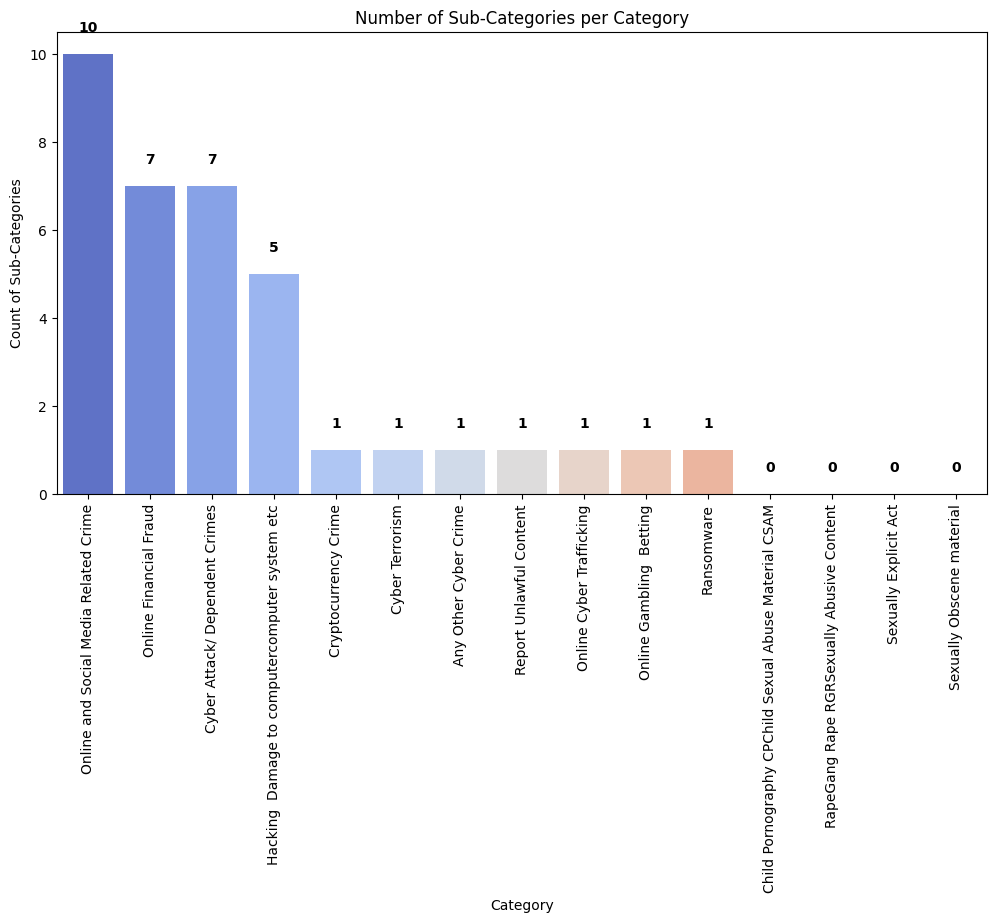

In [7]:
# 3. Plot for number of sub-categories in each category
plt.figure(figsize=(12, 6))
sub_category_in_category_counts = train.groupby('category')['sub_category'].nunique().sort_values(ascending=False)
sns.barplot(x=sub_category_in_category_counts.index, y=sub_category_in_category_counts.values, palette="coolwarm")
plt.title("Number of Sub-Categories per Category")
plt.xlabel("Category")
plt.ylabel("Count of Sub-Categories")

# Annotate the count above each bar
for i, v in enumerate(sub_category_in_category_counts.values):
    plt.text(i, v + 0.5, str(v), ha='center', fontweight='bold')

plt.xticks(rotation=90)  # Rotate x-ticks by 90 degrees
plt.show()

In [8]:
df_train = train.copy()
df_train = df_train.dropna(subset=["crimeaditionalinfo"])

In [9]:
# Ensure you have downloaded NLTK's punkt tokenizer
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Data Cleaning

In [10]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [11]:
def identify_noise(df):
    noise_info = {}
    abbreviations = re.compile(r'\b[A-Z]{2,4}\b')  # Common abbreviations pattern
    for text in df['crimeaditionalinfo'].dropna():
        found_abbreviations = abbreviations.findall(text)
        for abbr in found_abbreviations:
            noise_info[abbr] = noise_info.get(abbr, 0) + 1  # Count occurrences
    return dict(sorted(noise_info.items(), key=lambda item: item[1], reverse=True))

noise_summary = identify_noise(df_train)
print("Identified Noise and Abbreviations:\n", noise_summary)

Identified Noise and Abbreviations:
 {'BANK': 18823, 'AND': 16700, 'THE': 13681, 'IN': 11664, 'UPI': 9768, 'TAKE': 9640, 'HOLD': 8530, 'OF': 6920, 'SBI': 6240, 'MY': 6065, 'NO': 6054, 'ID': 5479, 'TO': 5171, 'MALL': 5153, 'AREA': 5146, 'SAHA': 5133, 'OTP': 4995, 'ME': 4099, 'CARD': 4054, 'RS': 3341, 'PM': 3198, 'PE': 3118, 'PAY': 2905, 'HE': 2804, 'FROM': 2779, 'IS': 2730, 'UTR': 2614, 'RD': 2608, 'BAG': 2578, 'BBD': 2567, 'IZAZ': 2566, 'RUBY': 2565, 'JOKA': 2534, 'AC': 2449, 'THAT': 2440, 'SMS': 2202, 'ON': 2197, 'CALL': 2193, 'IFSC': 2167, 'TIME': 2139, 'HDFC': 2125, 'NAME': 2114, 'FOR': 2052, 'AM': 1932, 'ATM': 1895, 'KYC': 1821, 'DATE': 1820, 'THIS': 1795, 'INR': 1778, 'QR': 1777, 'PAN': 1616, 'HAI': 1556, 'SE': 1522, 'THEY': 1476, 'BY': 1438, 'OLX': 1438, 'HAVE': 1422, 'KI': 1312, 'APP': 1298, 'SIR': 1286, 'NOT': 1285, 'WAS': 1272, 'SO': 1177, 'LOAN': 1169, 'FIR': 1158, 'KE': 1095, 'AS': 1085, 'BUT': 1080, 'OR': 1053, 'HELP': 1044, 'MERE': 1007, 'THEN': 985, 'WITH': 945, 'YOU': 88

In [12]:
def pre_clean_text(text):
    text = text.lower()  # Lowercase conversion
    text = re.sub(r'\b[A-Z]{2,4}\b', ' ', text)  # Remove abbreviations identified earlier
    return text

df_train['cleaned_text'] = df_train['crimeaditionalinfo'].apply(pre_clean_text)

In [13]:
abbreviation_dict = {
    "atm": "automated teller machine",
    "id": "identification",
    "dr": "doctor"
}

In [14]:
def clean_text(text):
    # Standardize abbreviations
    for abbr, full_form in abbreviation_dict.items():
        text = re.sub(r'\b' + re.escape(abbr) + r'\b', full_form, text)
    # Remove HTML tags, punctuation, and excessive whitespace
    text = re.sub(r'<[^>]+>', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text
df_train['cleaned_text'] = df_train['cleaned_text'].apply(clean_text)

In [15]:
def normalize_tokenize(text):
    # Convert to lowercase, remove stop words
    words = [word for word in nltk.word_tokenize(text.lower()) if word.isalpha() and word not in stop_words]
    return words

df_train['tokens'] = df_train['cleaned_text'].apply(normalize_tokenize)

In [16]:
df_train['lemmatized_tokens'] = df_train['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

In [17]:
custom_dictionary = {
    "fraud": ["scam", "deceit", "trickery"],
    "theft": ["stealing", "robbery", "burglary"]
}

In [18]:
def tag_domain_terms(tokens, custom_dict):
    tagged_terms = []
    for word in tokens:
        for key, synonyms in custom_dict.items():
            if word in synonyms:
                tagged_terms.append(key)  # Replace synonym with standard term
            else:
                tagged_terms.append(word)
    return tagged_terms

df_train['tagged_terms'] = df_train['lemmatized_tokens'].apply(lambda x: tag_domain_terms(x, custom_dictionary))

In [19]:
print(df_train[['category', 'sub_category', 'crimeaditionalinfo', 'cleaned_text', 'tokens', 'lemmatized_tokens', 'tagged_terms']])

                                    category  \
0      Online and Social Media Related Crime   
1                     Online Financial Fraud   
2                   Online Gambling  Betting   
3      Online and Social Media Related Crime   
4                     Online Financial Fraud   
...                                      ...   
93681                 Online Financial Fraud   
93682                 Online Financial Fraud   
93683                 Online Financial Fraud   
93684  Online and Social Media Related Crime   
93685                 Online Financial Fraud   

                            sub_category  \
0      Cyber Bullying  Stalking  Sexting   
1                      Fraud CallVishing   
2               Online Gambling  Betting   
3                       Online Job Fraud   
4                      Fraud CallVishing   
...                                  ...   
93681     Internet Banking Related Fraud   
93682              EWallet Related Fraud   
93683                 UPI R

uni-gram, bi-grma and tri-gram analysis

In [20]:
# Define function to generate n-grams for a given text
def generate_ngrams(text, n):
    tokens = text.split()  # Assuming text is already tokenized and cleaned
    return list(ngrams(tokens, n))

# Initialize dictionaries to store n-grams frequency for each category
unigram_freq = defaultdict(Counter)
bigram_freq = defaultdict(Counter)
trigram_freq = defaultdict(Counter)

In [21]:
# Process each row to compute n-grams per category
for _, row in df_train.iterrows():
    category = row['category']
    text = ' '.join(row['lemmatized_tokens'])  # Using lemmatized tokens to avoid redundancy
    
    # Generate n-grams
    unigrams = generate_ngrams(text, 1)
    bigrams = generate_ngrams(text, 2)
    trigrams = generate_ngrams(text, 3)
    
    # Update frequency counts for each n-gram in the corresponding category
    unigram_freq[category].update(unigrams)
    bigram_freq[category].update(bigrams)
    trigram_freq[category].update(trigrams)

In [22]:
# Convert Counter results to DataFrames for easier visualization
def get_top_ngrams(ngram_dict, n=10):
    """Get top n n-grams for each category."""
    top_ngrams = {}
    for category, counter in ngram_dict.items():
        top_ngrams[category] = counter.most_common(n)
    return top_ngrams

top_unigrams = get_top_ngrams(unigram_freq)
top_bigrams = get_top_ngrams(bigram_freq)
top_trigrams = get_top_ngrams(trigram_freq)

In [23]:
# Display top n-grams for each category
print("Top Unigrams per Category:\n", top_unigrams)
print("\nTop Bigrams per Category:\n", top_bigrams)
print("\nTop Trigrams per Category:\n", top_trigrams)

Top Unigrams per Category:
 {'Online and Social Media Related Crime': [(('number',), 7768), (('video',), 7481), (('call',), 7118), (('account',), 7008), (('money',), 5760), (('please',), 5517), (('facebook',), 4774), (('identification',), 4531), (('help',), 4062), (('whatsapp',), 4014)], 'Online Financial Fraud': [(('amount',), 48750), (('account',), 44412), (('bank',), 40170), (('fraud',), 38295), (('number',), 27774), (('total',), 25163), (('r',), 22863), (('call',), 22611), (('money',), 22296), (('please',), 21534)], 'Online Gambling  Betting': [(('money',), 474), (('please',), 228), (('number',), 198), (('sir',), 189), (('amount',), 188), (('account',), 178), (('app',), 158), (('r',), 143), (('help',), 136), (('call',), 127)], 'RapeGang Rape RGRSexually Abusive Content': [(('area',), 20522), (('mall',), 12825), (('activity',), 10261), (('shamefull',), 10260), (('place',), 7699), (('involve',), 7695), (('gariahat',), 7695), (('sir',), 5302), (('person',), 5244), (('many',), 5162)], 

In [24]:
# Recurring terms and jargon
for category in df_train['category'].unique():
    print(f"\nCategory: {category}")
    print(f"Top Unigrams: {[word[0][0] for word in top_unigrams[category]]}")
    print(f"Top Bigrams: {[f'{word[0][0]} {word[0][1]}' for word in top_bigrams[category]]}")
    print(f"Top Trigrams: {[f'{word[0][0]} {word[0][1]} {word[0][2]}' for word in top_trigrams[category]]}")


Category: Online and Social Media Related Crime
Top Unigrams: ['number', 'video', 'call', 'account', 'money', 'please', 'facebook', 'identification', 'help', 'whatsapp']
Top Bigrams: ['video call', 'please help', 'social medium', 'asking money', 'facebook account', 'mobile number', 'whatsapp number', 'please take', 'facebook identification', 'take action']
Top Trigrams: ['please please please', 'help help help', 'please take action', 'take necessary action', 'take strict action', 'video social medium', 'please help sir', 'whatsapp video call', 'nude video call', 'sir please help']

Category: Online Financial Fraud
Top Unigrams: ['amount', 'account', 'bank', 'fraud', 'number', 'total', 'r', 'call', 'money', 'please']
Top Bigrams: ['total amount', 'take necessary', 'necessary action', 'amount please', 'account take', 'please hold', 'reverse total', 'hold reverse', 'complaint account', 'amount complaint']
Top Trigrams: ['take necessary action', 'account take necessary', 'total amount ple

In [25]:
display(df_train)

,category,sub_category,crimeaditionalinfo,cleaned_text,tokens,lemmatized_tokens,tagged_terms
0,Online and Social Media Related Crime,Cyber Bullying Stalking Sexting,I had continue received random calls and abusi...,i had continue received random calls and abusi...,"[continue, received, random, calls, abusive, m...","[continue, received, random, call, abusive, me...","[continue, continue, received, received, rando..."
1,Online Financial Fraud,Fraud CallVishing,The above fraudster is continuously messaging ...,the above fraudster is continuously messaging ...,"[fraudster, continuously, messaging, asking, p...","[fraudster, continuously, messaging, asking, p...","[fraudster, fraudster, continuously, continuou..."
2,Online Gambling Betting,Online Gambling Betting,He is acting like a police and demanding for m...,he is acting like a police and demanding for m...,"[acting, like, police, demanding, money, addin...","[acting, like, police, demanding, money, addin...","[acting, acting, like, like, police, police, d..."
3,Online and Social Media Related Crime,Online Job Fraud,In apna Job I have applied for job interview f...,in apna job i have applied for job interview f...,"[apna, job, applied, job, interview, telecalli...","[apna, job, applied, job, interview, telecalli...","[apna, apna, job, job, applied, applied, job, ..."
4,Online Financial Fraud,Fraud CallVishing,I received a call from lady stating that she w...,i received a call from lady stating that she w...,"[received, call, lady, stating, send, new, pho...","[received, call, lady, stating, send, new, pho...","[received, received, call, call, lady, lady, s..."
...,...,...,...,...,...,...,...
93681,Online Financial Fraud,Internet Banking Related Fraud,Identity theft Smishing SMS Fraud CreditDeb...,identity theft smishing sms fraud creditdebit ...,"[identity, theft, smishing, sms, fraud, credit...","[identity, theft, smishing, sm, fraud, creditd...","[identity, identity, theft, theft, smishing, s..."
93682,Online Financial Fraud,EWallet Related Fraud,RECEIVED CALL FROM NUMBER ASKING ABOUT phone ...,received call from number asking about phone p...,"[received, call, number, asking, phone, pay, c...","[received, call, number, asking, phone, pay, c...","[received, received, call, call, number, numbe..."
93683,Online Financial Fraud,UPI Related Frauds,Cyber Stalking Blackmailing PhoneSMSVOIP C...,cyber stalking blackmailing phonesmsvoip calls...,"[cyber, stalking, blackmailing, phonesmsvoip, ...","[cyber, stalking, blackmailing, phonesmsvoip, ...","[cyber, cyber, stalking, stalking, blackmailin..."
93684,Online and Social Media Related Crime,Online Matrimonial Fraud,Call karke bola ki aapka lotary laga ha aru AC...,call karke bola ki aapka lotary laga ha aru ac...,"[call, karke, bola, ki, aapka, lotary, laga, h...","[call, karke, bola, ki, aapka, lotary, laga, h...","[call, call, karke, karke, bola, bola, ki, ki,..."


vectorizing tf-idf, word2vec and bert

In [26]:
# Train Word2Vec model on the tokens with increased vector size
vector_size = 100  # Increase vector size to 100
word2vec_model = Word2Vec(sentences=df_train['lemmatized_tokens'], vector_size=vector_size, window=5, min_count=1, workers=4)

# Generate sentence vectors by averaging word vectors
def average_word2vec(tokens, model, vector_size):
    valid_tokens = [model.wv[token] for token in tokens if token in model.wv]
    if valid_tokens:
        return np.mean(valid_tokens, axis=0)
    else:
        return np.zeros(vector_size)

# Update the lambda to match the new Word2Vec vector size
df_train['word2vec_vector'] = df_train['lemmatized_tokens'].apply(lambda x: average_word2vec(x, word2vec_model, vector_size))

In [27]:
display(df_train)

,category,sub_category,crimeaditionalinfo,cleaned_text,tokens,lemmatized_tokens,tagged_terms,word2vec_vector
0,Online and Social Media Related Crime,Cyber Bullying Stalking Sexting,I had continue received random calls and abusi...,i had continue received random calls and abusi...,"[continue, received, random, calls, abusive, m...","[continue, received, random, call, abusive, me...","[continue, continue, received, received, rando...","[0.6730804, -0.9246263, 0.41590685, -0.613511,..."
1,Online Financial Fraud,Fraud CallVishing,The above fraudster is continuously messaging ...,the above fraudster is continuously messaging ...,"[fraudster, continuously, messaging, asking, p...","[fraudster, continuously, messaging, asking, p...","[fraudster, fraudster, continuously, continuou...","[0.7163166, -0.97137326, 1.1001483, 0.7256879,..."
2,Online Gambling Betting,Online Gambling Betting,He is acting like a police and demanding for m...,he is acting like a police and demanding for m...,"[acting, like, police, demanding, money, addin...","[acting, like, police, demanding, money, addin...","[acting, acting, like, like, police, police, d...","[0.5560369, -1.2632987, 0.41925767, -0.3829097..."
3,Online and Social Media Related Crime,Online Job Fraud,In apna Job I have applied for job interview f...,in apna job i have applied for job interview f...,"[apna, job, applied, job, interview, telecalli...","[apna, job, applied, job, interview, telecalli...","[apna, apna, job, job, applied, applied, job, ...","[0.04313632, -0.057154804, -0.03691761, -0.059..."
4,Online Financial Fraud,Fraud CallVishing,I received a call from lady stating that she w...,i received a call from lady stating that she w...,"[received, call, lady, stating, send, new, pho...","[received, call, lady, stating, send, new, pho...","[received, received, call, call, lady, lady, s...","[0.17807099, -0.16438003, -0.14125808, -0.4315..."
...,...,...,...,...,...,...,...,...
93681,Online Financial Fraud,Internet Banking Related Fraud,Identity theft Smishing SMS Fraud CreditDeb...,identity theft smishing sms fraud creditdebit ...,"[identity, theft, smishing, sms, fraud, credit...","[identity, theft, smishing, sm, fraud, creditd...","[identity, identity, theft, theft, smishing, s...","[1.1382897, 0.012277596, 0.069571406, -0.56235..."
93682,Online Financial Fraud,EWallet Related Fraud,RECEIVED CALL FROM NUMBER ASKING ABOUT phone ...,received call from number asking about phone p...,"[received, call, number, asking, phone, pay, c...","[received, call, number, asking, phone, pay, c...","[received, received, call, call, number, numbe...","[0.2637429, 0.037147883, 0.09996563, 0.8857974..."
93683,Online Financial Fraud,UPI Related Frauds,Cyber Stalking Blackmailing PhoneSMSVOIP C...,cyber stalking blackmailing phonesmsvoip calls...,"[cyber, stalking, blackmailing, phonesmsvoip, ...","[cyber, stalking, blackmailing, phonesmsvoip, ...","[cyber, cyber, stalking, stalking, blackmailin...","[0.5488477, -0.631852, 1.068149, -0.6597172, -..."
93684,Online and Social Media Related Crime,Online Matrimonial Fraud,Call karke bola ki aapka lotary laga ha aru AC...,call karke bola ki aapka lotary laga ha aru ac...,"[call, karke, bola, ki, aapka, lotary, laga, h...","[call, karke, bola, ki, aapka, lotary, laga, h...","[call, call, karke, karke, bola, bola, ki, ki,...","[-0.21895336, 0.46201345, 1.509089, 0.40684554..."


In [28]:
df_train['sub_category'] = df_train['sub_category'].fillna(df_train['category'])

In [29]:
# Initialize SGDClassifier with logistic regression settings
X_word2vec = np.array(df_train['word2vec_vector'].tolist())
y_category = df_train['category']
y_sub_category = df_train['sub_category']

# Encode target labels
label_encoder_category = LabelEncoder()
y_category_encoded = label_encoder_category.fit_transform(y_category)

label_encoder_sub_category = LabelEncoder()
y_sub_category_encoded = label_encoder_sub_category.fit_transform(y_sub_category)

# Split the data into training and validation sets for categories
X_train_cat, X_val_cat, y_train_cat, y_val_cat = train_test_split(X_word2vec, y_category_encoded, test_size=0.2, random_state=42)

# Split the data into training and validation sets for sub-categories
X_train_sub_cat, X_val_sub_cat, y_train_sub_cat, y_val_sub_cat = train_test_split(X_word2vec, y_sub_category_encoded, test_size=0.2, random_state=42)

# Define batch processing function for logistic regression
def batch_process_logistic_regression(X_train, y_train, X_val, y_val, embedding_name, target_name, batch_size):
    num_batches = len(X_train) // batch_size + 1
    y_pred = []

    # Get unique classes from the training labels
    unique_classes = np.unique(y_train)

    # Initialize SGDClassifier for each target
    sgd_clf = SGDClassifier(loss="log", max_iter=1000, tol=1e-3, random_state=42)

    # Train in batches
    for batch_num in range(num_batches):
        start = batch_num * batch_size
        end = start + batch_size
        X_batch = X_train[start:end]
        y_batch = y_train[start:end]
        
        # Perform partial fit on each batch with all classes
        sgd_clf.partial_fit(X_batch, y_batch, classes=unique_classes)

    # Predict probabilities on validation data
    y_proba = sgd_clf.predict_proba(X_val)
    
    # Predict class labels on validation data
    y_pred = sgd_clf.predict(X_val)
    
    # Evaluate metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average="weighted")
    recall = recall_score(y_val, y_pred, average="weighted")
    f1 = f1_score(y_val, y_pred, average="weighted")
    # roc_auc = roc_auc_score(y_val, y_proba, multi_class="ovr")

    print(f"Results for {embedding_name} - {target_name}:")
    print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

# Set batch size and process for Category
batch_size = 500  # Adjust batch size as needed
batch_process_logistic_regression(X_train_cat, y_train_cat, X_val_cat, y_val_cat, "Word2Vec", "Category", batch_size)

# Process with Word2Vec for Sub-Category
batch_process_logistic_regression(X_train_sub_cat, y_train_sub_cat, X_val_sub_cat, y_val_sub_cat, "Word2Vec", "Sub_Category", batch_size)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Results for Word2Vec - Category:
Accuracy: 0.666204024982651, Precision: 0.7090546674243551, Recall: 0.666204024982651, F1 Score: 0.6445136812086766
Results for Word2Vec - Sub_Category:
Accuracy: 0.3498638765814338, Precision: 0.42014144441405343, Recall: 0.3498638765814338, F1 Score: 0.34136327797830707


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
# Initialize Word2Vec vectors and encode target labels
X_word2vec = np.array(df_train['word2vec_vector'].tolist())
y_category = df_train['category']
y_sub_category = df_train['sub_category']

# Encode target labels
label_encoder_category = LabelEncoder()
y_category_encoded = label_encoder_category.fit_transform(y_category)

label_encoder_sub_category = LabelEncoder()
y_sub_category_encoded = label_encoder_sub_category.fit_transform(y_sub_category)

# Split the data into training and validation sets for categories
X_train_cat, X_val_cat, y_train_cat, y_val_cat = train_test_split(X_word2vec, y_category_encoded, test_size=0.2, random_state=42)

# Split the data into training and validation sets for sub-categories
X_train_sub_cat, X_val_sub_cat, y_train_sub_cat, y_val_sub_cat = train_test_split(X_word2vec, y_sub_category_encoded, test_size=0.2, random_state=42)

# Define function for XGBClassifier
def process_xgboost(X_train, y_train, X_val, y_val, embedding_name, target_name):
    # Initialize XGBClassifier
    xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    
    # Fit on the full training data
    xgb_clf.fit(X_train, y_train)

    # Predict class labels on validation data
    y_pred = xgb_clf.predict(X_val)

    # Evaluate metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average="weighted", zero_division=0)
    recall = recall_score(y_val, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_val, y_pred, average="weighted", zero_division=0)
    
    print(f"Results for {embedding_name} - {target_name}:")
    print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

# Process for Category
process_xgboost(X_train_cat, y_train_cat, X_val_cat, y_val_cat, "Word2Vec", "Category")

# Process for Sub-Category
process_xgboost(X_train_sub_cat, y_train_sub_cat, X_val_sub_cat, y_val_sub_cat, "Word2Vec", "Sub_Category")

Results for Word2Vec - Category:
Accuracy: 0.7646933219452303, Precision: 0.7255572069172153, Recall: 0.7646933219452303, F1 Score: 0.7320648692579053
Results for Word2Vec - Sub_Category:
Accuracy: 0.5231943628890193, Precision: 0.5025301884227327, Recall: 0.5231943628890193, F1 Score: 0.4970948430426546


In [31]:
# Initialize Word2Vec vectors and encode target labels
X_word2vec = np.array(df_train['word2vec_vector'].tolist())
y_category = df_train['category']
y_sub_category = df_train['sub_category']

# Encode target labels
label_encoder_category = LabelEncoder()
y_category_encoded = label_encoder_category.fit_transform(y_category)

label_encoder_sub_category = LabelEncoder()
y_sub_category_encoded = label_encoder_sub_category.fit_transform(y_sub_category)

# Split the data into training and validation sets for categories
X_train_cat, X_val_cat, y_train_cat, y_val_cat = train_test_split(X_word2vec, y_category_encoded, test_size=0.2, random_state=42)

# Split the data into training and validation sets for sub-categories
X_train_sub_cat, X_val_sub_cat, y_train_sub_cat, y_val_sub_cat = train_test_split(X_word2vec, y_sub_category_encoded, test_size=0.2, random_state=42)

# Define function for LightGBM
def process_lightgbm(X_train, y_train, X_val, y_val, embedding_name, target_name):
    # Create LightGBM datasets
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

    # Set LightGBM parameters
    params = {
        'objective': 'multiclass',
        'num_class': len(np.unique(y_train)),  # Number of unique classes
        'metric': 'multi_logloss',
        'boosting_type': 'gbdt',
        'learning_rate': 0.1,
        'num_leaves': 31,
        'verbose': -1,
        'random_state': 42
    }

    # Train the model with early stopping
    model = lgb.train(
        params,
        train_data,
        valid_sets=[train_data, val_data],
        valid_names=['train', 'valid'],
        num_boost_round=1000
    )

    # Predict class labels on validation data
    y_pred = model.predict(X_val)
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Evaluate metrics
    accuracy = accuracy_score(y_val, y_pred_labels)
    precision = precision_score(y_val, y_pred_labels, average="weighted", zero_division=0)
    recall = recall_score(y_val, y_pred_labels, average="weighted", zero_division=0)
    f1 = f1_score(y_val, y_pred_labels, average="weighted", zero_division=0)
    
    print(f"Results for {embedding_name} - {target_name}:")
    print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

# Process for Category
process_lightgbm(X_train_cat, y_train_cat, X_val_cat, y_val_cat, "Word2Vec", "Category")

# Process for Sub-Category
process_lightgbm(X_train_sub_cat, y_train_sub_cat, X_val_sub_cat, y_val_sub_cat, "Word2Vec", "Sub_Category")

Results for Word2Vec - Category:
Accuracy: 0.6292104841723163, Precision: 0.5869077651334961, Recall: 0.6292104841723163, F1 Score: 0.5824565691530675
Results for Word2Vec - Sub_Category:
Accuracy: 0.2842577270058186, Precision: 0.20990143759747307, Recall: 0.2842577270058186, F1 Score: 0.16825644801651082


In [32]:
# Initialize Word2Vec vectors and encode target labels
X_word2vec = np.array(df_train['word2vec_vector'].tolist())
y_category = df_train['category']
y_sub_category = df_train['sub_category']

# Encode target labels
label_encoder_category = LabelEncoder()
y_category_encoded = label_encoder_category.fit_transform(y_category)

label_encoder_sub_category = LabelEncoder()
y_sub_category_encoded = label_encoder_sub_category.fit_transform(y_sub_category)

# Split the data into training and validation sets for categories
X_train_cat, X_val_cat, y_train_cat, y_val_cat = train_test_split(X_word2vec, y_category_encoded, test_size=0.2, random_state=42)

# Split the data into training and validation sets for sub-categories
X_train_sub_cat, X_val_sub_cat, y_train_sub_cat, y_val_sub_cat = train_test_split(X_word2vec, y_sub_category_encoded, test_size=0.2, random_state=42)

# Define function for CatBoost
def process_catboost(X_train, y_train, X_val, y_val, embedding_name, target_name):
    # Initialize CatBoost Classifier
    model = CatBoostClassifier(
        iterations=1000,          # Number of boosting iterations
        learning_rate=0.1,       # Learning rate
        depth=6,                 # Depth of the tree
        eval_metric='MultiClass', # Evaluation metric
        random_seed=42,
        verbose=100,             # Print updates every 100 iterations
        early_stopping_rounds=100 # Stop training if no improvement for 100 rounds
    )

    # Fit the model
    model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=True)

    # Predict class labels on validation data
    y_pred = model.predict(X_val)

    # Evaluate metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average="weighted", zero_division=0)
    recall = recall_score(y_val, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_val, y_pred, average="weighted", zero_division=0)
    
    print(f"Results for {embedding_name} - {target_name}:")
    print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

# Process for Category
process_catboost(X_train_cat, y_train_cat, X_val_cat, y_val_cat, "Word2Vec", "Category")

# Process for Sub-Category
process_catboost(X_train_sub_cat, y_train_sub_cat, X_val_sub_cat, y_val_sub_cat, "Word2Vec", "Sub_Category")

0:	learn: 1.9927681	test: 1.9891177	best: 1.9891177 (0)	total: 1.01s	remaining: 16m 48s
1:	learn: 1.7382529	test: 1.7337002	best: 1.7337002 (1)	total: 1.9s	remaining: 15m 46s
2:	learn: 1.5753497	test: 1.5702193	best: 1.5702193 (2)	total: 2.79s	remaining: 15m 26s
3:	learn: 1.4536631	test: 1.4481330	best: 1.4481330 (3)	total: 3.66s	remaining: 15m 11s
4:	learn: 1.3594723	test: 1.3540258	best: 1.3540258 (4)	total: 4.54s	remaining: 15m 3s
5:	learn: 1.2802803	test: 1.2748822	best: 1.2748822 (5)	total: 5.43s	remaining: 14m 59s
6:	learn: 1.2159190	test: 1.2103499	best: 1.2103499 (6)	total: 6.32s	remaining: 14m 56s
7:	learn: 1.1602659	test: 1.1547944	best: 1.1547944 (7)	total: 7.2s	remaining: 14m 53s
8:	learn: 1.1122688	test: 1.1070206	best: 1.1070206 (8)	total: 8.13s	remaining: 14m 55s
9:	learn: 1.0729156	test: 1.0676944	best: 1.0676944 (9)	total: 9.01s	remaining: 14m 52s
10:	learn: 1.0361724	test: 1.0311666	best: 1.0311666 (10)	total: 9.89s	remaining: 14m 49s
11:	learn: 1.0069169	test: 1.0019

In [33]:
# Initialize Word2Vec vectors and encode target labels
X_word2vec = np.array(df_train['word2vec_vector'].tolist())
y_category = df_train['category']
y_sub_category = df_train['sub_category']

# Encode target labels
label_encoder_category = LabelEncoder()
y_category_encoded = label_encoder_category.fit_transform(y_category)

label_encoder_sub_category = LabelEncoder()
y_sub_category_encoded = label_encoder_sub_category.fit_transform(y_sub_category)

# Split the data into training and validation sets for categories
X_train_cat, X_val_cat, y_train_cat, y_val_cat = train_test_split(X_word2vec, y_category_encoded, test_size=0.2, random_state=42)

# Split the data into training and validation sets for sub-categories
X_train_sub_cat, X_val_sub_cat, y_train_sub_cat, y_val_sub_cat = train_test_split(X_word2vec, y_sub_category_encoded, test_size=0.2, random_state=42)

# Define function for Gaussian Naive Bayes
def process_gaussian_naive_bayes(X_train, y_train, X_val, y_val, embedding_name, target_name):
    # Initialize Gaussian Naive Bayes Classifier
    gnb_classifier = GaussianNB()

    # Fit the model
    gnb_classifier.fit(X_train, y_train)

    # Predict class labels on validation data
    y_pred = gnb_classifier.predict(X_val)

    # Evaluate metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average="weighted", zero_division=0)
    recall = recall_score(y_val, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_val, y_pred, average="weighted", zero_division=0)
    
    print(f"Results for {embedding_name} - {target_name}:")
    print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

# Process for Category
process_gaussian_naive_bayes(X_train_cat, y_train_cat, X_val_cat, y_val_cat, "Word2Vec", "Category")

# Process for Sub-Category
process_gaussian_naive_bayes(X_train_sub_cat, y_train_sub_cat, X_val_sub_cat, y_val_sub_cat, "Word2Vec", "Sub_Category")

Results for Word2Vec - Category:
Accuracy: 0.48305129984519296, Precision: 0.7532614737945285, Recall: 0.48305129984519296, F1 Score: 0.5621019434791734
Results for Word2Vec - Sub_Category:
Accuracy: 0.3143650242886884, Precision: 0.45191355876476597, Recall: 0.3143650242886884, F1 Score: 0.34604892434576107


In [34]:
# Initialize Word2Vec vectors and encode target labels
X_word2vec = np.array(df_train['word2vec_vector'].tolist())
y_category = df_train['category']
y_sub_category = df_train['sub_category']

# Encode target labels
label_encoder_category = LabelEncoder()
y_category_encoded = label_encoder_category.fit_transform(y_category)

label_encoder_sub_category = LabelEncoder()
y_sub_category_encoded = label_encoder_sub_category.fit_transform(y_sub_category)

# Split the data into training and validation sets for categories
X_train_cat, X_val_cat, y_train_cat, y_val_cat = train_test_split(X_word2vec, y_category_encoded, test_size=0.2, random_state=42)

# Split the data into training and validation sets for sub-categories
X_train_sub_cat, X_val_sub_cat, y_train_sub_cat, y_val_sub_cat = train_test_split(X_word2vec, y_sub_category_encoded, test_size=0.2, random_state=42)

# Define function for Random Forest
def process_random_forest(X_train, y_train, X_val, y_val, embedding_name, target_name):
    # Initialize Random Forest Classifier
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

    # Fit the model
    rf_classifier.fit(X_train, y_train)

    # Predict class labels on validation data
    y_pred = rf_classifier.predict(X_val)

    # Evaluate metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average="weighted", zero_division=0)
    recall = recall_score(y_val, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_val, y_pred, average="weighted", zero_division=0)
    
    print(f"Results for {embedding_name} - {target_name}:")
    print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

# Process for Category
process_random_forest(X_train_cat, y_train_cat, X_val_cat, y_val_cat, "Word2Vec", "Category")

# Process for Sub-Category
process_random_forest(X_train_sub_cat, y_train_sub_cat, X_val_sub_cat, y_val_sub_cat, "Word2Vec", "Sub_Category")

Results for Word2Vec - Category:
Accuracy: 0.764319649815833, Precision: 0.7331297010493055, Recall: 0.764319649815833, F1 Score: 0.7175772145689395
Results for Word2Vec - Sub_Category:
Accuracy: 0.5337639459776864, Precision: 0.5265231490398813, Recall: 0.5337639459776864, F1 Score: 0.4956549233942796
